In [287]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser
from ripser import Rips
import persim
from persim import landscapes
import pytz
timezone =  pytz.FixedOffset(-240)

In [2]:
# Get the path of the notebook file
notebook_path = os.path.abspath('__file__')

# Directory containing the notebook file
notebook_directory = os.path.dirname(notebook_path)

In [3]:
# Specify the path to your Parquet file
parquet_file_path = notebook_directory+'/Data/train_series.parquet'

# If you want to convert the Table to a Pandas DataFrame, you can do the following:
df = pd.read_parquet(parquet_file_path)

## Loading and labelling training set

In [10]:
train_events = pd.read_csv(notebook_directory+"/Data/train_events.csv")

In [11]:
# Convert the 'date_column' to datetime
train_events['timestamp'] = pd.to_datetime(train_events['timestamp'], format='%Y-%m-%dT%H:%M:%S%z')

In [12]:
train_events

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14 22:26:00-04:00
1,038441c925bb,1,wakeup,10932.0,2018-08-15 06:41:00-04:00
2,038441c925bb,2,onset,20244.0,2018-08-15 19:37:00-04:00
3,038441c925bb,2,wakeup,27492.0,2018-08-16 05:41:00-04:00
4,038441c925bb,3,onset,39996.0,2018-08-16 23:03:00-04:00
...,...,...,...,...,...
14503,fe90110788d2,33,wakeup,560604.0,2017-09-06 04:07:00-04:00
14504,fe90110788d2,34,onset,574620.0,2017-09-06 23:35:00-04:00
14505,fe90110788d2,34,wakeup,581604.0,2017-09-07 09:17:00-04:00
14506,fe90110788d2,35,onset,NaN,NaN


## Labelling whether in a particular step that person is sleeping or not

In [13]:
train_events[train_events["night"] == 0+1][(train_events[train_events["night"] == 0+1])["event"] == "onset"]["step"].iloc[0]

4992.0

In [14]:
max_night = max(train_events["night"].tolist())
max_step = max(train_events["step"].tolist())
max_night,max_step

(84, 739392.0)

In [15]:
label_event = {}

for id in train_events.series_id.unique().tolist():
    night = 0
    step = 0
    train_event_fil_id = train_events[train_events["series_id"] == id]
    df_activity = pd.DataFrame()
    activity_list = []
    sure = True

    while night < max_night and step < max_step: 
       
        train_events_fil_id_night = train_event_fil_id[train_event_fil_id["night"] == night+1]
        
        if len(train_events_fil_id_night) != 0:# checking whether or not we have any night information for that day
            step_onset = train_events_fil_id_night[train_events_fil_id_night["event"] == "onset"]["step"].iloc[0]
            step_wakeup = train_events_fil_id_night[train_events_fil_id_night["event"] == "wakeup"]["step"].iloc[0]
            if sure:
                if  not np.isnan(step_onset) and not np.isnan(step_wakeup):
                    activity_list += ["active"]*int(step_onset-step-1)
                    activity_list.append("onset")
                    activity_list += ["sleep"]*int(step_wakeup-step_onset-1)
                    activity_list.append("wakeup")
                    step = step_wakeup
                    sure = True
                    night +=1
                else:
                    night += 1
                    sure = False
            else:
                if  not np.isnan(step_onset) and not np.isnan(step_wakeup):
                    activity_list += ["unknown"]*int(step_onset-step-1)
                    activity_list.append("onset")
                    activity_list += ["sleep"]*int(step_wakeup-step_onset-1)
                    activity_list.append("wakeup")
                    step = step_wakeup
                    sure = True
                    night +=1
                else:
                    night += 1
                    sure = False

            step_wakeup = train_events_fil_id_night[train_events_fil_id_night["event"] == "wakeup"]["step"].iloc[0]


        else:
            night += 1
    df_activity["activity"] = activity_list
    label_event[id] = df_activity

In [34]:
label_event['038441c925bb'].iloc[3]["activity"]

'active'

## Generating embedding

In [55]:
def generate_point_cloud_embedding_enmo(time_series,label,series_id_num,window_size,step_size):
    #times_series: Is the series that we are considering
    #label: labelling for the series
    #series_id_num: Is the series that we are targeting
    #window_size: Is the window length that we are targeting
    #step_size: is the size that we want to embed for

    # Specify the 'series_id' you want to filter by
    target_series_id = series_id_num

    # Filter rows with the specified 'series_id'
    filtered_time_series = time_series[time_series['series_id'] == target_series_id]

    embedding_for_diff_window_enmo_active = []
    embedding_for_diff_window_enmo_sleep = []

    start = 0
    end = 0+window_size
    while end<len(label[series_id_num]):

        activities = ((label[series_id_num].iloc[start:end])["activity"].unique()).tolist()
        if len(activities) == 1:
            if activities[0] == "active":
                x = filtered_time_series.iloc[start:end]
                embedding_enmo = []
                j = 0
                while j < len(x)-step_size:
                
                    embed_enmo = []
                    for i in range(step_size):
                        
                        embed_enmo.append(x["enmo"].iloc[j+i])
                
                    embedding_enmo.append(embed_enmo)
                    j += 1
                if len(embedding_enmo)!=0:
                    embedding_for_diff_window_enmo_active.append(np.array(embedding_enmo))
            elif activities[0] == "sleep":
                x = filtered_time_series.iloc[start:end]
                embedding_enmo = []
                j = 0
                while j < len(x)-step_size:
                
                    embed_enmo = []
                    for i in range(step_size):
                        
                        embed_enmo.append(x["enmo"].iloc[j+i])
                
                    embedding_enmo.append(embed_enmo)
                    j += 1
                if len(embedding_enmo)!=0:
                    embedding_for_diff_window_enmo_sleep.append(np.array(embedding_enmo))
        start += window_size
        end += window_size
            
    return embedding_for_diff_window_enmo_active,embedding_for_diff_window_enmo_sleep

In [143]:
selected_series = df.series_id.unique()[0]
selected_series

'038441c925bb'

In [144]:
enmo_active, enmo_sleep = generate_point_cloud_embedding_enmo(df,label_event,selected_series,720,200)

In [288]:
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA

data = enmo_active[20]
# Assuming you have already performed PCA and have 'reduced_data'
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(data)

# Create a DataFrame from the reduced data
plot_df = pd.DataFrame(data=reduced_data, columns=['PC1', 'PC2', 'PC3'])

# Add a new column for the rank of each point
plot_df['Rank'] = range(1, len(plot_df) + 1)

# Create an interactive 3D scatter plot using Plotly, coloring by rank
fig = px.scatter_3d(plot_df, x='PC1', y='PC2', z='PC3', color='Rank')

# Customize the plot layout, labels, and other settings as needed
fig.update_layout(
    title='PCA Plot in 3D with Rank-based Coloring 200 step size'
)

fig.update_traces(marker_size = 2)

# Show the plot
fig.show()


In [152]:
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA

data = enmo_sleep[20]
# Assuming you have already performed PCA and have 'reduced_data'
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(data)

# Create a DataFrame from the reduced data
plot_df = pd.DataFrame(data=reduced_data, columns=['PC1', 'PC2', 'PC3'])

# Add a new column for the rank of each point
plot_df['Rank'] = range(1, len(plot_df) + 1)

# Create an interactive 3D scatter plot using Plotly, coloring by rank
fig = px.scatter_3d(plot_df, x='PC1', y='PC2', z='PC3', color='Rank')

# Customize the plot layout, labels, and other settings as needed
fig.update_layout(
    title='PCA Plot in 3D with Rank-based Coloring 200 step size'
)

fig.update_traces(marker_size = 2)

# Show the plot
fig.show()


In [147]:
rips = Rips(maxdim=1)

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


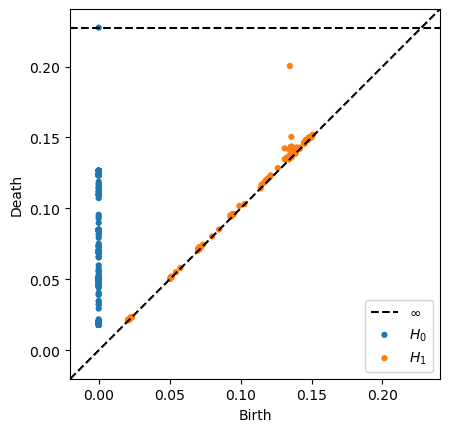

In [148]:
dgm_sleep = rips.fit_transform(enmo_sleep[20])
persim.plot_diagrams(dgm_sleep,show=True)

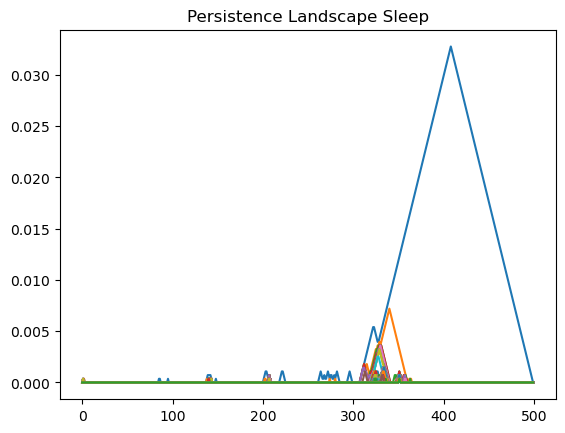

In [149]:
landscaper = landscapes.PersistenceLandscaper(hom_deg=1)
# Compute flattened persistence landscape
landscaper.fit(dgm_sleep)
result = landscaper.transform(dgm_sleep)
# Sample list of lists representing functions
function_data = result

# Create a plot for each function
for i, data in enumerate(function_data):
    plt.plot(data, label=f'Function {i + 1}')

# Add labels and legend
plt.title("Persistence Landscape Sleep")

# Show the plot
plt.show()

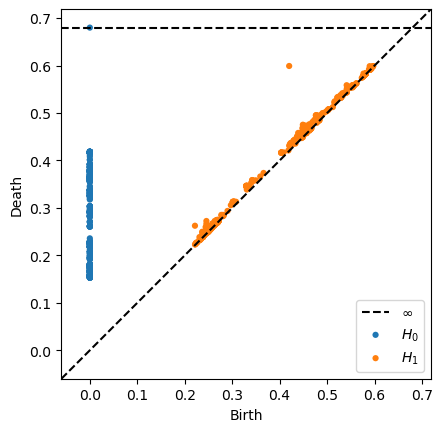

In [150]:
dgm_active = rips.fit_transform(enmo_active[20])
persim.plot_diagrams(dgm_active,show=True)

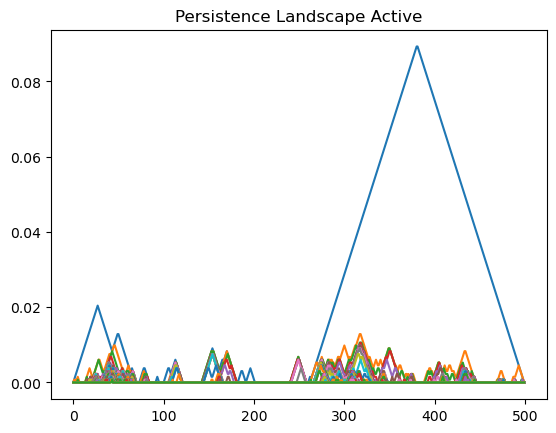

In [151]:
landscaper = landscapes.PersistenceLandscaper(hom_deg=1)
# Compute flattened persistence landscape
landscaper.fit(dgm_active)
result = landscaper.transform(dgm_active)
# Sample list of lists representing functions
function_data = result

# Create a plot for each function
for i, data in enumerate(function_data):
    plt.plot(data, label=f'Function {i + 1}')

# Add labels and legend
plt.title("Persistence Landscape Active")

# Show the plot
plt.show()

In [272]:
from persim.landscapes import (
    PersLandscapeApprox,
    average_approx,
    snap_pl,
    plot_landscape,
    plot_landscape_simple
)

In [275]:
lands = []

for embed in enmo_active:
    rips_active = rips.fit_transform(embed)

    if len(rips_active[1]) != 0:
        lands.append(PersLandscapeApprox(dgms=rips_active,hom_deg=1))

In [328]:
avg = average_approx(lands)
avg.values

array([[0.00000000e+00, 7.86940510e-07, 8.19693139e-06, ...,
        1.19354599e-04, 5.96772995e-05, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 5.86255437e-06, ...,
        1.19354599e-04, 5.96772995e-05, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 4.75738793e-06, ...,
        1.07683900e-05, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

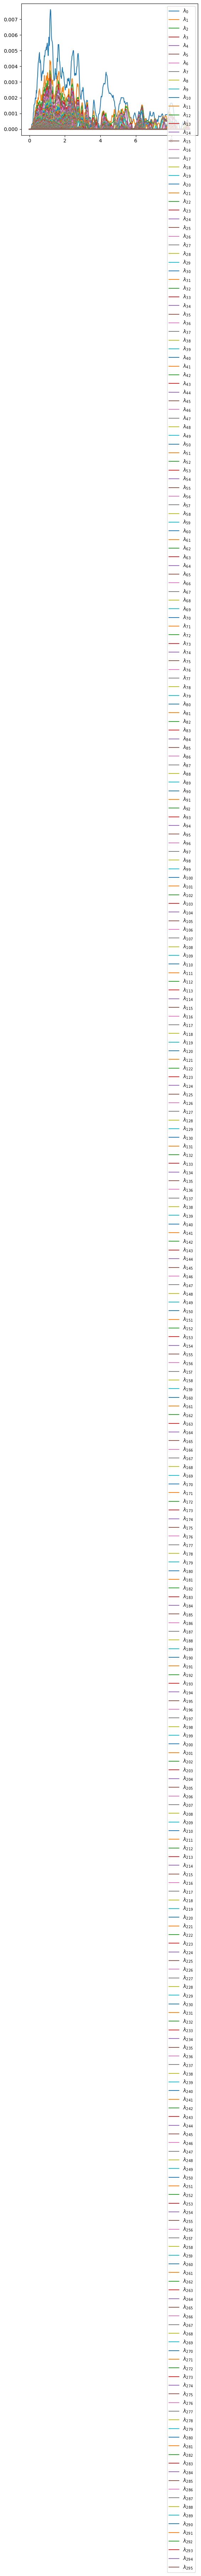

In [299]:
%matplotlib inline
plot_landscape_simple(avg)

In [264]:
len_of_land = []
for i in range(len(lands)):
    len_of_land.append(len(lands[i]))
max_len = max(len_of_land)

av_land = []
initial = np.array([[0.0]*500]*max_len)
j = 0
while j < max_len:
    for i in range(len(lands)):
        if j < len(lands[i]):
            initial[j] += lands[i][j]
        initial[j] *= 1/float(len(lands))
    j += 1

In [302]:
lands_sleep = []

for embed in enmo_sleep:
    rips_active = rips.fit_transform(embed)

    if len(rips_active[1]) != 0:
        lands_sleep.append(PersLandscapeApprox(dgms=rips_active,hom_deg=1))

In [303]:
avg_sleep = average_approx(lands_sleep)

In [327]:
avg_sleep.values

array([[0.00000000e+00, 0.00000000e+00, 3.78030785e-06, ...,
        2.13150842e-05, 1.06575421e-05, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.06626894e-05, 1.06575421e-05, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.03313447e-05, 1.03313447e-05, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

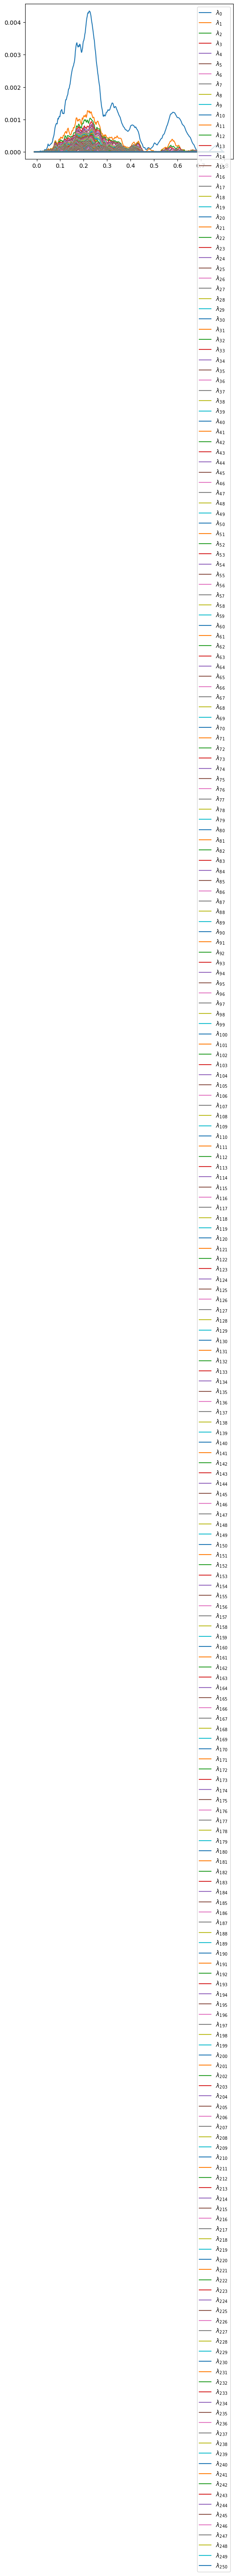

In [304]:
%matplotlib inline
plot_landscape_simple(avg_sleep)

In [305]:
[avg_active_snapped, avg_sleep_snapped] = snap_pl([avg, avg_sleep])
true_diff_pl = avg_active_snapped - avg_sleep_snapped
significance = true_diff_pl.sup_norm()

print(f'The threshold for significance is {significance}.')

The threshold for significance is 0.007617535359500541.


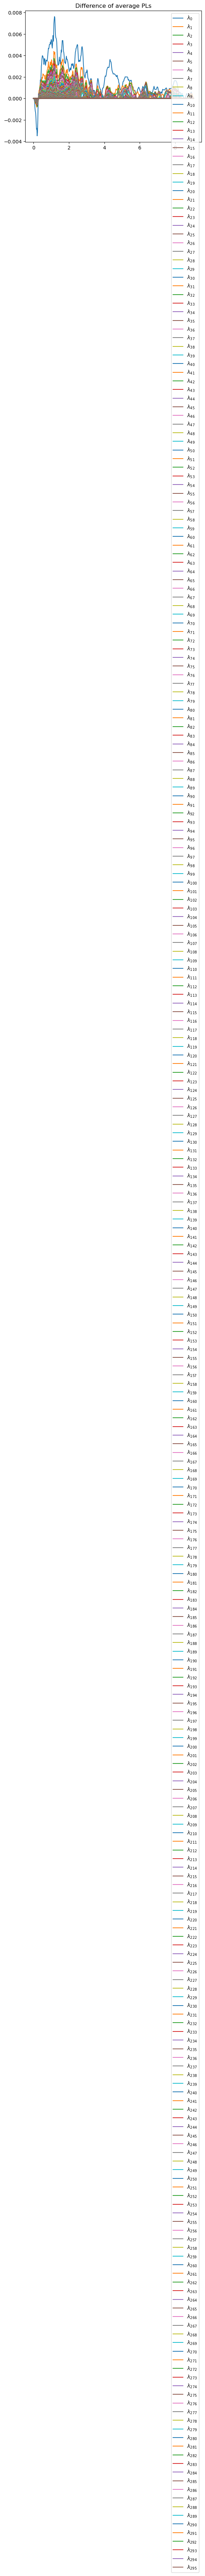

In [309]:
plot_landscape_simple(true_diff_pl,title='Difference of average PLs')

## Computing Average Persistence Landsacpe for Active and Sleep State for every person

In [412]:
#initializing the dictionary
#lands_dic = {}

In [434]:
#storing unique series id to call them again
series_list = df["series_id"].unique().tolist()

In [472]:
#missed_id = ["0cd1e3d0ed95","0dee4fda51c3","0f9e60a8e56d","1319a1935f48","154fe824ed87","1716cd4163b2","207eded97727"]

In [491]:
n = 150
for id in series_list[150:]:

    print(f"Processing step: {n}")  # Print the current step
    n += 1 
    try:
        #generating the embedding
        enmo_active, enmo_sleep = generate_point_cloud_embedding_enmo(df,label_event,id,720,200)

        #initializing the list to store average landscape for each unique id
        lands_active = []

        #generating rips filtration for each embedding
        for embed in enmo_active:
            rips_active = rips.fit_transform(embed)

            if len(rips_active[1]) != 0:#checking whether or not we have deg 1 feature in our embedding
                lands_active.append(PersLandscapeApprox(dgms=rips_active,hom_deg=1,num_steps=1000))
        
        #repeating the same process for sleep embedding
        lands_sleep = []
        for embed in enmo_sleep:
            rips_sleep = rips.fit_transform(embed)

            if len(rips_sleep[1]) != 0:
                lands_sleep.append(PersLandscapeApprox(dgms=rips_sleep,hom_deg=1,num_steps=1000))

        #storing the average landscape as value in dictionary so that I can acess it with the id as key
        lands_dic[id] = (average_approx(lands_active),average_approx(lands_sleep))
    
    except Exception as e:
        # Handle the error, you can print an error message or take other actions
        missed_id.append(id)
        print(f"Error processing id {id}: {str(e)}")

Processing step: 150
Processing step: 151
Processing step: 152
Processing step: 153
Processing step: 154
Bad choice of grid, values is empty
Error processing id 939932f1822d: object of too small depth for desired array
Processing step: 155
Processing step: 156
Bad choice of grid, values is empty
Error processing id 99237ce045e4: object of too small depth for desired array
Processing step: 157
Processing step: 158
Processing step: 159
Processing step: 160
Processing step: 161
Bad choice of grid, values is empty
Error processing id 9c91c546e095: object of too small depth for desired array
Processing step: 162
Processing step: 163
Processing step: 164
Processing step: 165
Bad choice of grid, values is empty
Error processing id a167532acca2: object of too small depth for desired array
Processing step: 166
Processing step: 167
Processing step: 168
Error processing id a3e59c2ce3f6: min() arg is an empty sequence
Processing step: 169
Processing step: 170
Processing step: 171
Processing step: 

In [492]:
import pickle

# Save the dictionary to a file using Pickle
with open(notebook_directory+'/Data/saved_land_dict.pkl', 'wb') as file:
    pickle.dump(lands_dic, file)

# Load the dictionary from the file
with open(notebook_directory+'/Data/saved_land_dict.pkl', 'rb') as file:
    loaded_dict = pickle.load(file)

In [493]:
len(loaded_dict)

230

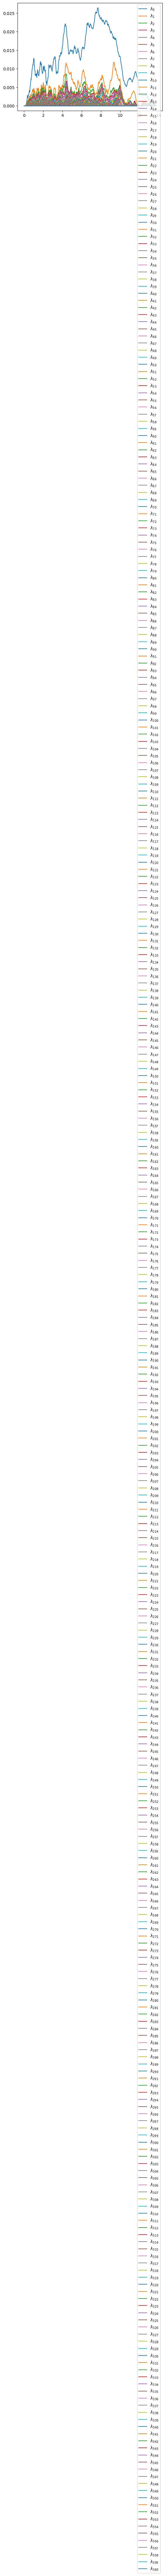

In [482]:
%matplotlib inline
plot_landscape_simple(lands_dic[series_list[47]][0])

## Exploring average PL

In [537]:
list_of_av_pl = list(loaded_dict.values())
av_sleep_pl = []
av_active_pl = []
for pair in list_of_av_pl:
    av_active_pl.append(pair[0].values.flatten().tolist())
    av_sleep_pl.append(pair[1].values.flatten().tolist())

In [561]:
# Find the maximum length of the sublists
max_length = max(max(len(sublist) for sublist in av_active_pl),max(len(sublist) for sublist in av_sleep_pl))
print(max_length)

# Pad the shorter sublists with zeros
av_active_pl_padded_list = [sublist + [0] * (max_length - len(sublist)) for sublist in av_active_pl]

# Pad the shorter sublists with zeros
av_sleep_pl_padded_list = [sublist + [0] * (max_length - len(sublist)) for sublist in av_sleep_pl]

1020000


## PCA Projection

In [565]:
# Combine the datasets and create a new label vector
combined_data = np.concatenate((av_active_pl_padded_list, av_sleep_pl_padded_list), axis=0)
active_labels = np.ones(len(av_active_pl_padded_list))
sleep_labels = np.zeros(len(av_sleep_pl_padded_list))
combined_labels = np.concatenate((active_labels, sleep_labels))

In [566]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
combined_data_3D = pca.fit_transform(combined_data)

In [569]:
import plotly.express as px

# Assuming you have 'combined_data_3D' and 'combined_labels' from the previous code

plot_df = pd.DataFrame(data=combined_data_3D, columns=['PC1', 'PC2', 'PC3'])
plot_df['Label'] = combined_labels

# Define colors for active (red) and sleep (blue) points
color_map = {1: 'Active', 0: 'Sleep'}
plot_df['Color'] = plot_df['Label'].map(color_map)

# Create a 3D scatter plot using Plotly
fig = px.scatter_3d(plot_df, x='PC1', y='PC2', z='PC3', color='Color', symbol='Label', opacity=0.8)

# Customize the plot
fig.update_layout(scene=dict(xaxis_title='PC1', yaxis_title='PC2', zaxis_title='PC3'))
fig.update_traces(marker=dict(size=4))

# Show the plot
fig.show()


## SVM Classifier

## Linear

In [580]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Split the combined data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_data, combined_labels, test_size=0.2, random_state=42)

# Create an SVM classifier
svm_classifier_linear = SVC(kernel='linear', C=1.0, random_state=42)

# Train the SVM classifier on the training data
svm_classifier_linear.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = svm_classifier_linear.predict(X_test)

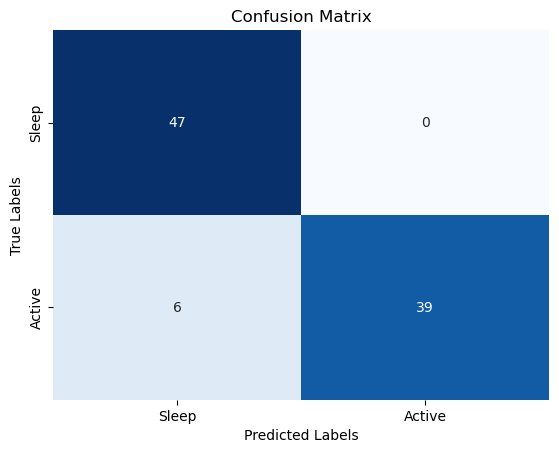

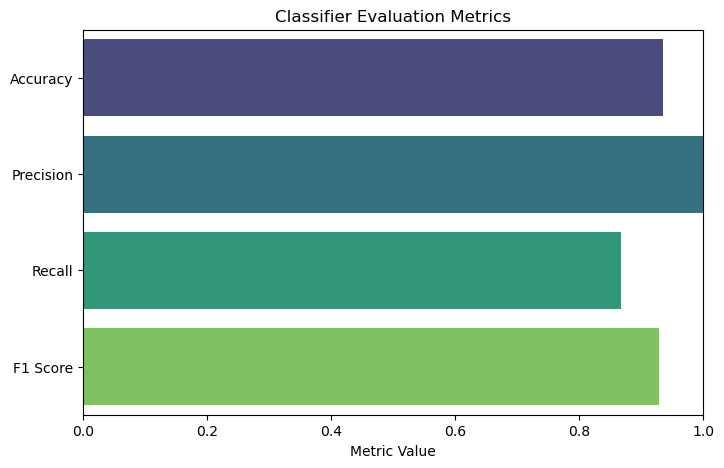

In [572]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Calculate the evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Define class labels
class_labels = ['Sleep', 'Active']

# Create a heatmap of the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Create a bar plot for accuracy, precision, recall, and F1 score
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(8, 5))
sns.barplot(x=values, y=metrics, palette='viridis')
plt.xlabel('Metric Value')
plt.title('Classifier Evaluation Metrics')
plt.xlim(0, 1)
plt.show()

## RBF Kernel

In [578]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Split the combined data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_data, combined_labels, test_size=0.2, random_state=42)

# Create an SVM classifier
svm_classifier_rbf = SVC(kernel='rbf', C=1.0, random_state=42)

# Train the SVM classifier on the training data
svm_classifier_rbf.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = svm_classifier_rbf.predict(X_test)

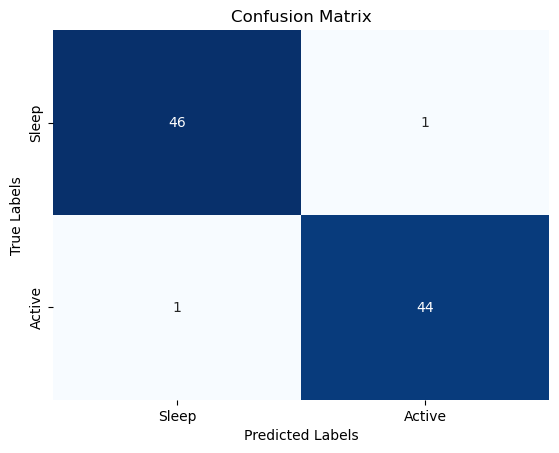

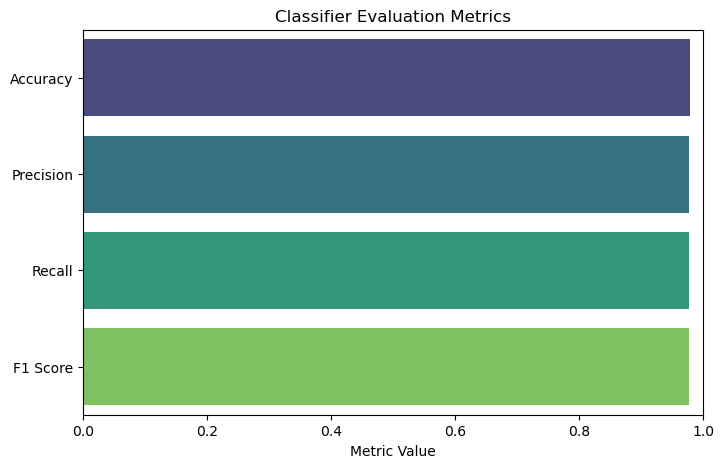

In [575]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Calculate the evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Define class labels
class_labels = ['Sleep', 'Active']

# Create a heatmap of the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Create a bar plot for accuracy, precision, recall, and F1 score
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(8, 5))
sns.barplot(x=values, y=metrics, palette='viridis')
plt.xlabel('Metric Value')
plt.title('Classifier Evaluation Metrics')
plt.xlim(0, 1)
plt.show()

## Poynomial Degree 3 Kernel


In [579]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Split the combined data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_data, combined_labels, test_size=0.2, random_state=42)

# Create an SVM classifier
svm_classifier_poly = SVC(kernel='poly', C=1.0, random_state=42)

# Train the SVM classifier on the training data
svm_classifier_poly.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = svm_classifier_poly.predict(X_test)

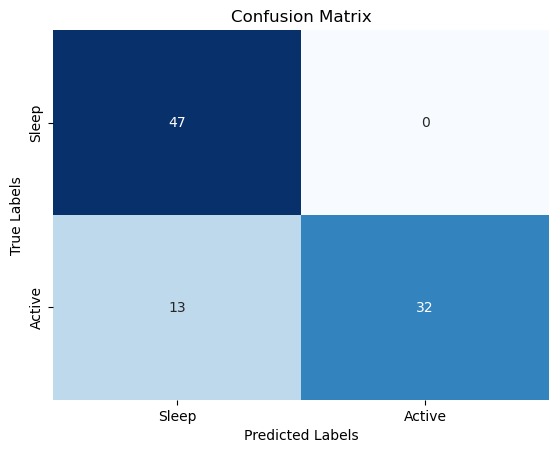

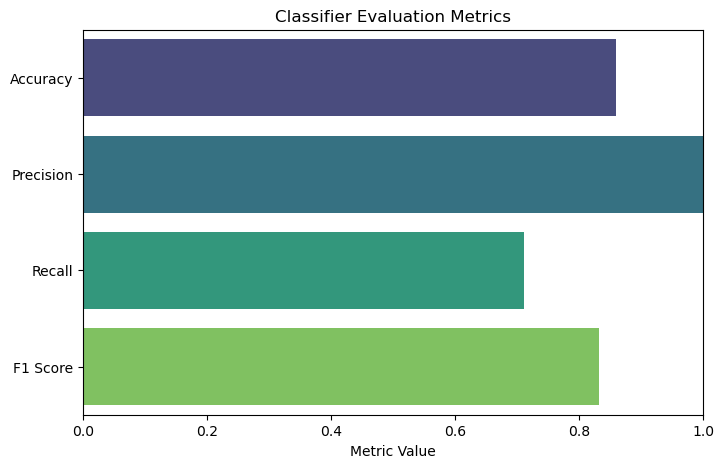

In [577]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Calculate the evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Define class labels
class_labels = ['Sleep', 'Active']

# Create a heatmap of the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Create a bar plot for accuracy, precision, recall, and F1 score
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(8, 5))
sns.barplot(x=values, y=metrics, palette='viridis')
plt.xlabel('Metric Value')
plt.title('Classifier Evaluation Metrics')
plt.xlim(0, 1)
plt.show()